In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from ddpm import DDPM

In [2]:
def dino_dataset(n=8000):
    df = pd.read_csv("datasaurus.csv")
    df = df[df["dataset"] == "dino"]
    rng = np.random.default_rng(42)
    ix = rng.integers(0, len(df), n)
    x = df["x"].iloc[ix].tolist()
    x = np.array(x) + rng.normal(size=len(x)) * 0.15
    y = df["y"].iloc[ix].tolist()
    y = np.array(y) + rng.normal(size=len(x)) * 0.15
    x = (x/54 - 1) * 4
    y = (y/48 - 1) * 4
    X = np.stack((x, y), axis=1)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))

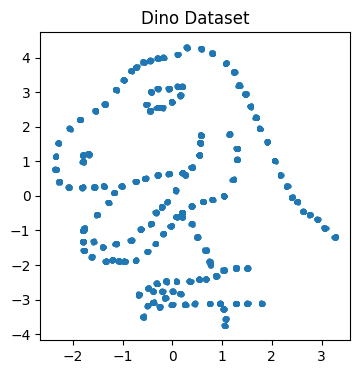

In [3]:
dataset = dino_dataset()

#plot dataset
plt.figure(figsize=(4, 4))
plt.scatter(dataset.tensors[0][:, 0], dataset.tensors[0][:, 1], s=5)
plt.title("Dino Dataset")
plt.show()

In [4]:
print("Dataset shape:", dataset.tensors[0].shape)

loader = DataLoader(dataset, batch_size=32, shuffle=True)

Dataset shape: torch.Size([8000, 2])


In [11]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb
    
    def __len__(self):
        return self.size
    
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128):
        super().__init__()

        self.time_mlp = SinusoidalEmbedding(emb_size)
        self.input_mlp1 = SinusoidalEmbedding(emb_size, scale=25.0)
        self.input_mlp2 = SinusoidalEmbedding(emb_size, scale=25.0)

        concat_size = len(self.time_mlp) + \
            len(self.input_mlp1) + len(self.input_mlp2)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        t = t.squeeze(1)
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

net = MLP(hidden_size=128, hidden_layers=3, emb_size=128)

ddpm = DDPM(200, net, (2,))
#ddpm.train(loader, 300)
ddpm.net.load_state_dict(torch.load("dino_model.pth"))

<All keys matched successfully>

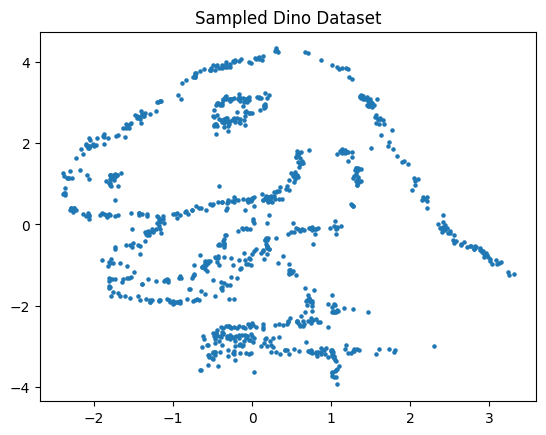

In [12]:
x = ddpm.sample(1000).detach().numpy()
plt.scatter(x[:,0], x[:,1], s=5)
plt.title("Sampled Dino Dataset")
plt.show()

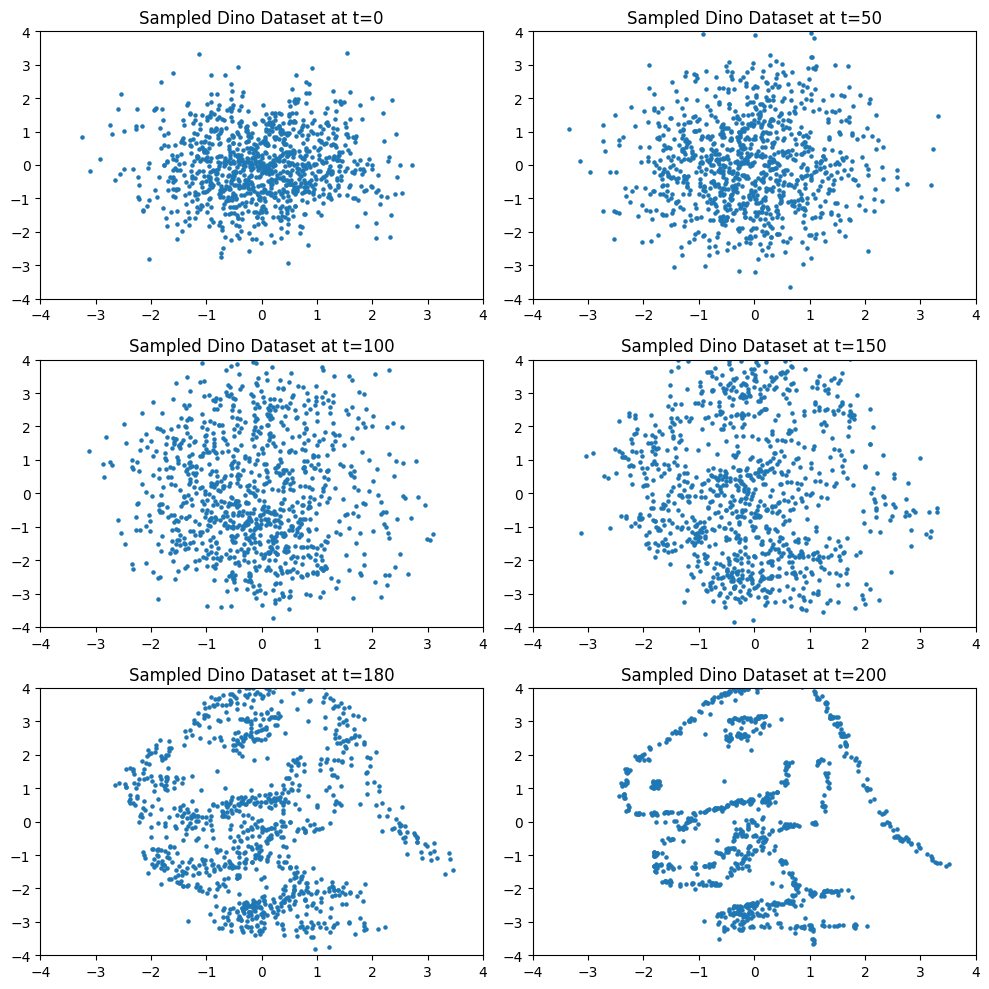

In [16]:
list_samples = ddpm.sample_evolution(1000).detach().numpy()
timesteps = [0, 50, 100, 150, 180, 200]
plt.figure(figsize=(10, 10))
for i, t in enumerate(timesteps):
    plt.subplot(3, 2, i + 1)
    plt.scatter(list_samples[t][:, 0], list_samples[t][:, 1], s=5)
    plt.title(f"Sampled Dino Dataset at t={t}")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
plt.tight_layout()
plt.show()

In [ ]:
#save model
#torch.save(ddpm.net.state_dict(), "dino_model_2.pth")